## [1. Import Needed Modules](#import) ##
## [2. Create train, test and validation dataframes](#makedf) ## 
## [3. Trim the train_df dataframe](#trim) ##
## [4. Balance the train_df dataframe](#balance) ## 
## [5. Create train, test and validation generators](#generators) ## 
## [6. Create a function to show Training Image Samples](#show) ## 
## [7. Create the Model](#model) ## 
## [8. Create a custom Keras callback to continue or halt training](#callback) ## 
## [9. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [10. Train the model](#train) ##
## [11. Define a function to plot the training data](#plot) ##
## [12. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [13. Save the model](#save) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

<a id="import"></a>
# <center>Make train, test and validation dataframes</center><a id="makedf"></a>
### I will create a model that will have 18 classes. The three mainclasses will be bad, good and mixed.
### The subclasses will be the fruits Apple, Banana, Guava, Lime , Orange ans Pomegranate.
### Iterate through the image directory and create the class labels and filepaths to create a dataframe
### and also calculate the average image height and width

In [2]:
sdir=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits'
bad_path=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits'
good_path=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits'
mixed_path=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits'
filepaths=[]
labels=[]
ht=0
wt=0
samples=0
sample_count=20
for quality in [bad_path, good_path, mixed_path]:    
    fruit_list=os.listdir(quality)
    for fruit in fruit_list:
        fruit_path=os.path.join(quality, fruit)
        img_list=os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path=os.path.join(fruit_path, img)
            if i < sample_count:
                img=plt.imread(img_path)               
                ht += img.shape[0]
                wt += img.shape[1]
                samples +=1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + '_mixed')
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
# split df into a train_df a valid_df and a test_df
trsplit=.9
vsplit=.05
dsplit =vsplit/(1-trsplit)
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=strat)
strat=dummy_df['labels']
test_df, valid_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
classes=list(train_df['labels'].unique())
class_count = len(classes)
groups=df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)
      samples=len(group)
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
wave=wt/samples
have=ht/samples
aspect_ratio= have/wave
print ('Average Image Height: ' ,have, '  Average Image Width: ', wave, '  Aspect ratio: ', aspect_ratio)

train_df lenght:  17573   test_df length:  976   valid_df length:  977
            CLASS               IMAGE COUNT 
           Lime_Bad                1085     
          Guava_Bad                1129     
       Pomegranate_Good            5940     
          Lime_Good                1094     
          Apple_Bad                1141     
          Orange_Bad               1159     
          Guava_Good               1152     
          Apple_Good               1149     
         Orange_Good               1216     
         Banana_mixed               285     
         Banana_Good               1113     
          Banana_Bad               1087     
       Pomegranate_Bad             1187     
         Guava_mixed                148     
         Lemon_mixed                278     
      Pomegranate_mixed             125     
         Apple_mixed                113     
         Orange_mixed               125     
Average Image Height:  721.152   Average Image Width:  702.528   Aspect ra

<a id="trim"></a>
# <center>Trim the train_df data frame</center>
### train_df is imbalance and has a large number of sample images for some classes like Lime_Bad
### but a small number of images likke for class Orange_mixed.
### To balance train_df first limit the maximum number of samples in a class to a value max_samples=200
### using the trim function defined below

In [3]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [4]:
max_samples=200
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  18
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 133, 113, 113, 102]


<a id="balance"></a>
# <center>Balance the train_df data frame</center>
### Now for classes that have less than 200 images we need to create augmented images for each class.
### Create a directory aug in the Kaggle working directory and below that create sub directories for each class
### create the augmented images and store the appropriate number in each class sub directory.
### create and aug_df from the aug directory and concatenate with the original train_df. The new train_df will
### have 200 images in each class. Use the balance function defined below.

In [5]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [6]:
working_dir=r'./'
img_size=(224,224)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  18
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 133, 113, 113, 102]
Found 133 validated image filenames.
Found 113 validated image filenames.
Found 102 validated image filenames.
Found 113 validated image filenames.
Total Augmented images created=  339
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


<a id="generators"></a>
# <center>Create the train_gen, test_gen and valid_gen</center>

In [7]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (300,233) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 3600 validated image filenames belonging to 18 classes.
Found 977 validated image filenames belonging to 18 classes.
Found 976 validated image filenames belonging to 18 classes.
test batch size:  61   test steps:  16  number of classes :  18
       class name        class index 
        Apple_Bad             0      
       Apple_Good             1      
       Apple_mixed            2      
       Banana_Bad             3      
       Banana_Good            4      
      Banana_mixed            5      
        Guava_Bad             6      
       Guava_Good             7      
       Guava_mixed            8      
       Lemon_mixed            9      
        Lime_Bad              10     
        Lime_Good             11     
       Orange_Bad             12     
       Orange_Good            13     
      Orange_mixed            14     
     Pomegranate_Bad          15     
    Pomegranate_Good          16     
    Pomegranate_mixed         17     


<a id="show"></a>
# <center>Create a function to show example training images</center>

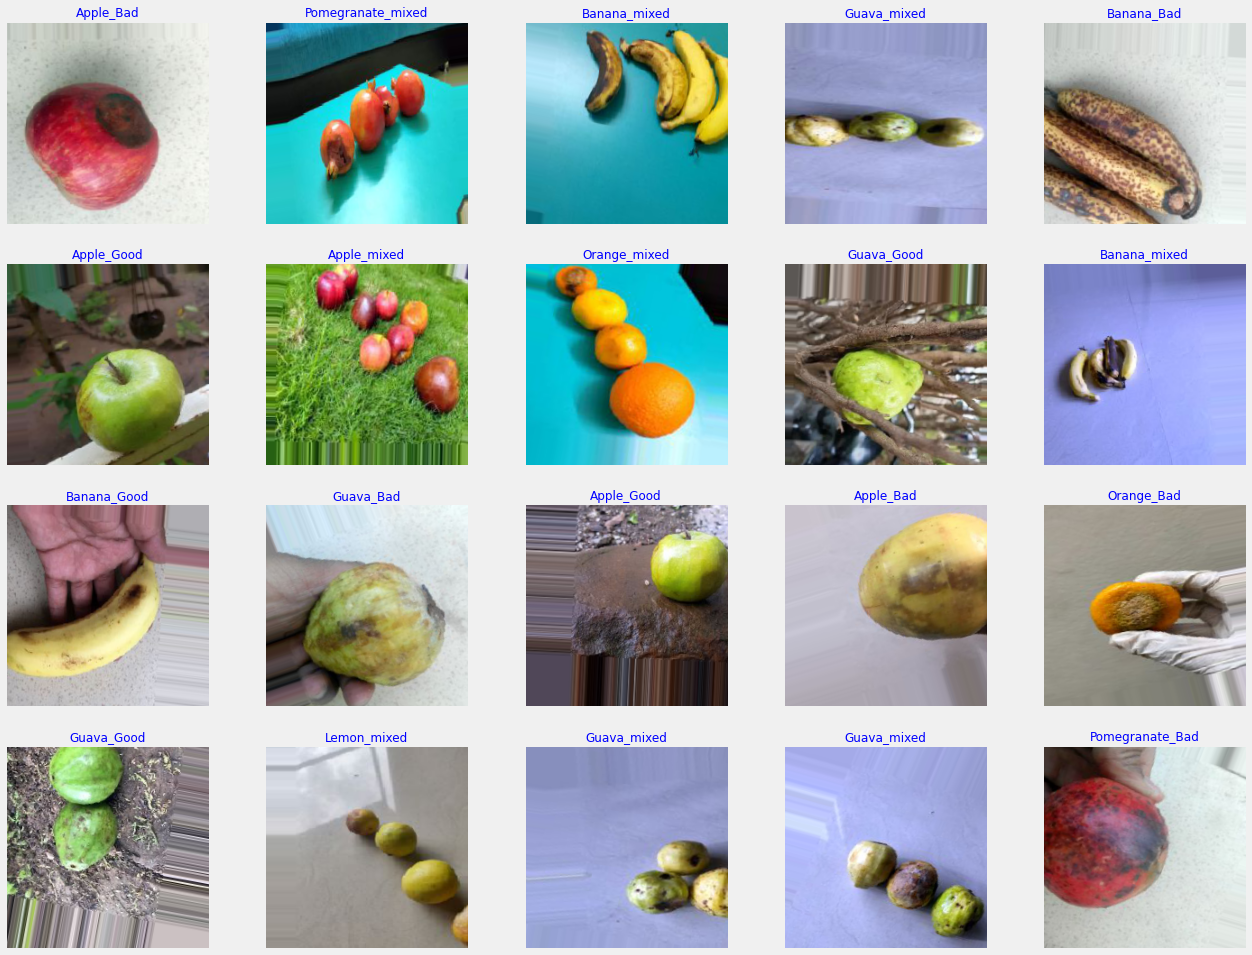

In [16]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>

In [8]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

2022-04-01 13:24:08.172538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 13:24:08.298399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 13:24:08.299522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 13:24:08.301765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

115277824/115263384 [==============================] - 3s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>

In [9]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="callbacks"></a>
# <center>Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [10]:
epochs=40
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [11]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40


2022-04-01 13:24:20.432027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-01 13:24:47.745163: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 149s 641ms/step - loss: 23.6205 - accuracy: 0.6408 - val_loss: 17.9243 - val_accuracy: 0.8976
Epoch 2/40
180/180 [==============================] - 105s 581ms/step - loss: 13.3538 - accuracy: 0.8917 - val_loss: 10.0374 - val_accuracy: 0.9519
Epoch 3/40
180/180 [==============================] - 106s 587ms/step - loss: 7.9504 - accuracy: 0.9444 - val_loss: 5.9156 - val_accuracy: 0.9775
Epoch 4/40
180/180 [==============================] - 106s 589ms/step - loss: 4.8791 - accuracy: 0.9647 - val_loss: 3.6659 - val_accuracy: 0.9846
Epoch 5/40
180/180 [==============================] - 106s 586ms/step - loss: 3.1194 - accuracy: 0.9700 - val_loss: 2.3945 - val_accuracy: 0.9846

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 5


you entered  5  Training will continue to epoch  10
Epoch 6/40
180/180 [==============================] - 106s 588ms/step - loss: 2.0781 - accuracy: 0.9853 - val_loss: 1.6395 - val_accuracy: 0.9836
Epoch 7/40
180/180 [==============================] - 106s 589ms/step - loss: 1.5140 - accuracy: 0.9800 - val_loss: 1.2389 - val_accuracy: 0.9816
Epoch 8/40
180/180 [==============================] - 105s 584ms/step - loss: 1.1768 - accuracy: 0.9861 - val_loss: 0.9670 - val_accuracy: 0.9857
Epoch 9/40
180/180 [==============================] - 105s 585ms/step - loss: 0.9581 - accuracy: 0.9869 - val_loss: 0.7961 - val_accuracy: 0.9877
Epoch 10/40
180/180 [==============================] - 106s 587ms/step - loss: 0.8132 - accuracy: 0.9917 - val_loss: 0.7186 - val_accuracy: 0.9816

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 2


you entered  2  Training will continue to epoch  12
Epoch 11/40
180/180 [==============================] - 106s 587ms/step - loss: 0.7321 - accuracy: 0.9908 - val_loss: 0.6285 - val_accuracy: 0.9846
Epoch 12/40
180/180 [==============================] - 106s 585ms/step - loss: 0.6679 - accuracy: 0.9931 - val_loss: 0.6006 - val_accuracy: 0.9867

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 h


you entered  h  Training halted on epoch  12  due to user input

training elapsed time was 0.0 hours, 23.0 minutes, 7.86 seconds)


<a id="plot"></a>
# <center>Define a function to plot the training data

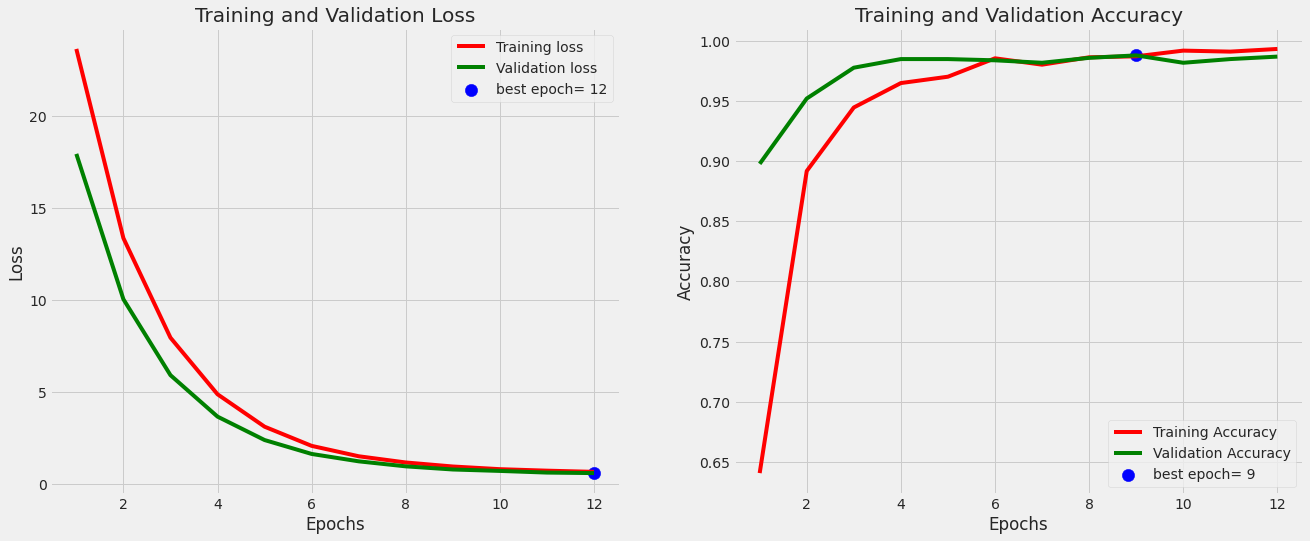

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make predictions on test set, create Confusion Matrix and Classification Results

16/16 [==============================] - 12s 772ms/step
there were 11 in 976 tests for an accuracy of  98.87


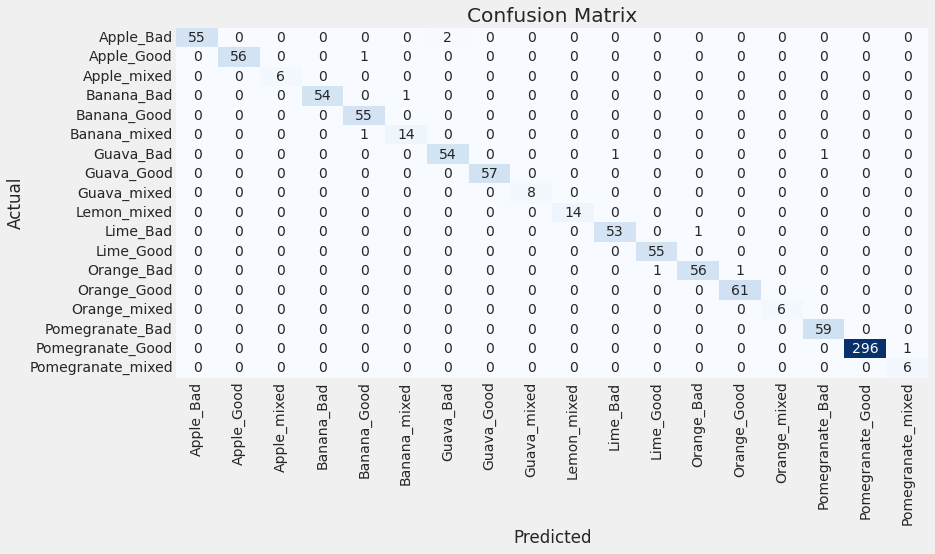

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     1.0000    0.9649    0.9821        57
       Apple_Good     1.0000    0.9825    0.9912        57
      Apple_mixed     1.0000    1.0000    1.0000         6
       Banana_Bad     1.0000    0.9818    0.9908        55
      Banana_Good     0.9649    1.0000    0.9821        55
     Banana_mixed     0.9333    0.9333    0.9333        15
        Guava_Bad     0.9643    0.9643    0.9643        56
       Guava_Good     1.0000    1.0000    1.0000        57
      Guava_mixed     1.0000    1.0000    1.0000         8
      Lemon_mixed     1.0000    1.0000    1.0000        14
         Lime_Bad     0.9815    0.9815    0.9815        54
        Lime_Good     0.9821    1.0000    0.9910        55
       Orange_Bad     0.9825    0.9655    0.9739        58
      Orange_Good     0.9839    1.0000    0.9919        61
     Orange_mixed     1.0000    1.0000    1.0000         6
  Pomegr

In [15]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

<a id="save"></a>
# <center>Save the model

In [26]:
subject='Indian Fruit' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

model was saved as  ./Indian Fruit_98.87.h5
